In [24]:
import pandas as pd
from matplotlib import pyplot as plt

In [25]:
df = pd.read_csv("data/report.tsv",sep="\t")
df_filtered = df[df["Q.Value"] < 0.01]
df_tr = pd.read_csv("data/prosit_ptm_2020.csv")

df_grad_length = abs(df["iRT"].max()-df["iRT"].min())
df_grad_length_ptm = abs(df_tr["tr"].max()-df_tr["tr"].min())

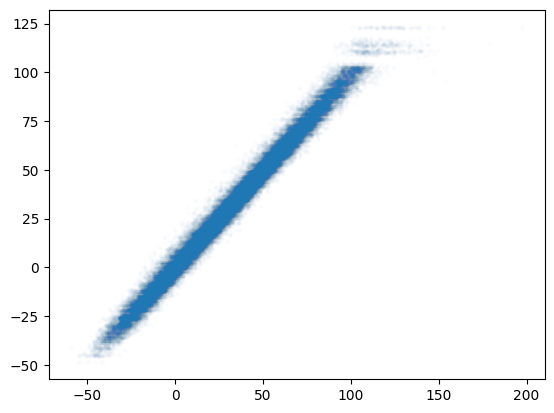

In [26]:
plt.scatter(df_filtered["iRT"],df_filtered["Predicted.iRT"],s=4,alpha=0.01)

In [45]:
df_tr.fillna("",inplace=True)
for g in df_tr.groupby("seq"):
    print(g)

# Separate unmodified and modified peptides
df_unmod = df_tr[df_tr["modifications"] == ""].rename(columns={"tr": "tr_unmod"})
df_mod = df_tr[df_tr["modifications"] != ""]

# Merge on sequence to get corresponding unmodified tr for each modified one
df_merged = pd.merge(df_mod, df_unmod[["seq", "tr_unmod"]], on="seq", how="left")

# Calculate RT difference
df_merged["delta_tr"] = df_merged["tr"] - df_merged["tr_unmod"]

# Optional: sort for readability
df_merged = df_merged.sort_values(by="seq")

# Step 2: Extract only the modification types from the modification string
# Example: "18|Methyl|9|Carbamidomethyl" -> ["Methyl", "Carbamidomethyl"]
def extract_mod_types(mod_str):
    if not mod_str:
        return []
    parts = mod_str.split('|')
    return [parts[i] for i in range(1, len(parts), 2)]

# Create a column of modification lists
df_merged["mod_types"] = df_merged["modifications"].apply(extract_mod_types)
df_merged = df_merged[df_merged["mod_types"].apply(len) == 1].copy()
df_merged["mod_types"] = [mt[0] for mt in df_merged["mod_types"]]

('AAGGAPLSCFICGGGIGR',                      seq                                   modifications  \
2503  AAGGAPLSCFICGGGIGR  18|Methyl|9|Carbamidomethyl|12|Carbamidomethyl   

            tr  
2503  44.53325  )
('AAGGAPLSCFICGGGIGRGK',                        seq                                      modifications  \
182   AAGGAPLSCFICGGGIGRGK     18|Methyl|9|Carbamidomethyl|12|Carbamidomethyl   
705   AAGGAPLSCFICGGGIGRGK   18|Dimethyl|9|Carbamidomethyl|12|Carbamidomethyl   
3031  AAGGAPLSCFICGGGIGRGK               9|Carbamidomethyl|12|Carbamidomethyl   
5224  AAGGAPLSCFICGGGIGRGK  18|Deamidated|9|Carbamidomethyl|12|Carbamidome...   

             tr  
182   40.843250  
705   41.188375  
3031  40.492750  
5224  43.764250  )
('AAGPSLSHTSGGTQSK',                    seq modifications         tr
1126  AAGPSLSHTSGGTQSK                11.674375)
('AAGQPYEQHAK',               seq modifications         tr
1653  AAGQPYEQHAK                10.841250
2696  AAGQPYEQHAK     6|Phospho  11.039525
5080

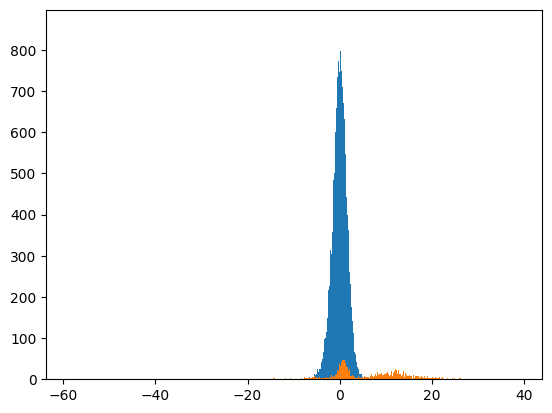

In [46]:
plt.hist((df_filtered["iRT"]-df_filtered["Predicted.iRT"])/df_grad_length*100,bins=1000)
plt.hist((df_merged["delta_tr"])/df_grad_length_ptm*100,bins=1000)
plt.show()

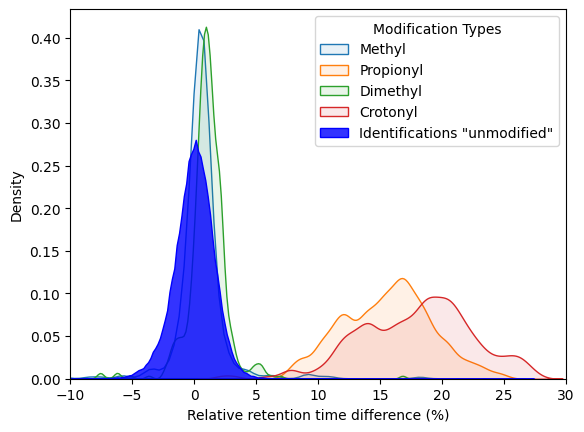

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Using df_merged with columns "delta_tr" and "mod_types"
values_col = (df_merged["delta_tr"]) / df_grad_length_ptm * 100
df_merged["adjusted_delta_tr"] = values_col  # Create a new column for easier plotting

selected_mods = ["Methyl", "Propionyl", "Dimethyl", "Crotonyl"]
# Plot KDE for each mod_type group
for mod_type in selected_mods:
    subset = df_merged[df_merged["mod_types"] == mod_type]
    sns.kdeplot(subset["adjusted_delta_tr"], bw_adjust=0.5, fill=True, alpha=0.1, label=mod_type)

sns.kdeplot(values_1, bw_adjust=0.5, color='blue', fill=True, alpha=0.8,  label='Identifications "unmodified"')
plt.xlim(-10,30)
plt.legend()
plt.xlabel('Relative retention time difference (%)')
plt.ylabel('Density')

plt.legend(title='Modification Types')
plt.savefig("img/retention_time_prediction_real_exp.svg")
plt.show()

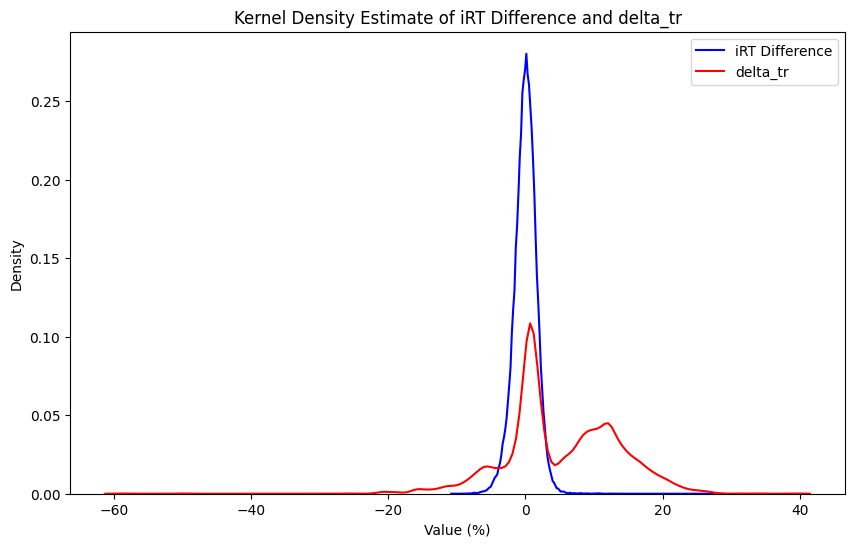

In [54]:
plt.figure(figsize=(10, 6))
sns.kdeplot(values_1, bw_adjust=0.5, color='blue', label='iRT Difference')
sns.kdeplot(values_2, bw_adjust=0.5, color='red', label='delta_tr')
plt.title('Kernel Density Estimate of iRT Difference and delta_tr')
plt.xlabel('Value (%)')
plt.ylabel('Density')
plt.legend()
plt.show()


In [31]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [34]:
df_merged

,seq,modifications,tr,tr_unmod,delta_tr
2170,AAGGAPLSCFICGGGIGR,18|Methyl|9|Carbamidomethyl|12|Carbamidomethyl,44.533250,NaN,NaN
4494,AAGGAPLSCFICGGGIGRGK,18|Deamidated|9|Carbamidomethyl|12|Carbamidome...,43.764250,NaN,NaN
2477,AAGGAPLSCFICGGGIGRGK,9|Carbamidomethyl|12|Carbamidomethyl,40.492750,NaN,NaN
58,AAGGAPLSCFICGGGIGRGK,18|Methyl|9|Carbamidomethyl|12|Carbamidomethyl,40.843250,NaN,NaN
554,AAGGAPLSCFICGGGIGRGK,18|Dimethyl|9|Carbamidomethyl|12|Carbamidomethyl,41.188375,NaN,NaN
...,...,...,...,...,...
4352,YTTNNSSEQR,1|Nitro,13.404000,10.44615,2.957850
4362,YVGESEANIR,1|Nitro,26.503000,23.08575,3.417250
2352,YVGESEANIR,1|Phospho,24.435375,23.08575,1.349625
2211,YVHADAPTNK,1|Nitro,15.378250,12.46375,2.914500
